In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/itemreads.pkl','rb'))

## Dataset and DataLoader

In [4]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [5]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [6]:
df_train.shape

(185974, 77806)

In [7]:
bs=64

In [8]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [9]:
df['rating'].min(),df['rating'].max()

(1, 10)

In [10]:
df_train.shape

(185974, 77806)

In [11]:
len(dltrain)

2906

## Create the Model Architecture for the Encoder

In [12]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [13]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [14]:
n_item_final=25

In [28]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0,0,0])

In [29]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=77806, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=100, out_features=77806, bias=True)
  (criterion): MSELoss()
)

In [30]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[10.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  7.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  7.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])


In [31]:
Xb.size()

torch.Size([64, 77806])

In [32]:
Xb.squeeze(0)

tensor([[10.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  7.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  7.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [33]:
preds,loss,preds_train=autoenc.forward(Xb)

In [34]:
loss.backward()

In [35]:
preds.size()

torch.Size([64, 77806])

In [36]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [37]:
device="cuda:0"

In [38]:
wd=1e-4
#wd=1e-1

In [39]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [40]:
len(dltrain)

2906

In [41]:
import matplotlib.pyplot as plt

In [42]:
dltrain.batch_size

64

In [43]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [51]:
if 1==0:
    del autoenc
    torch.cuda.empty_cache()

In [52]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [53]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=77806, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=100, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=100, out_features=77806, bias=True)
  (criterion): MSELoss()
)

In [54]:
len(dltrain)

2906

In [55]:
learner.lr_find(1e-3,3e-1,dltrain,len(dltrain))

Batch:1000 4.8663411140441895 4.817765712738037 
Batch:2000 5.05087423324585 4.96852970123291 


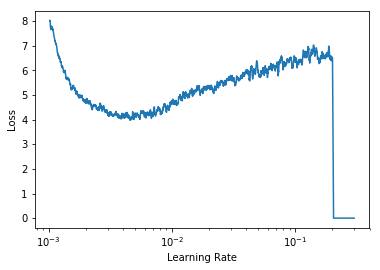

In [56]:
learner.plot_lrs(10)

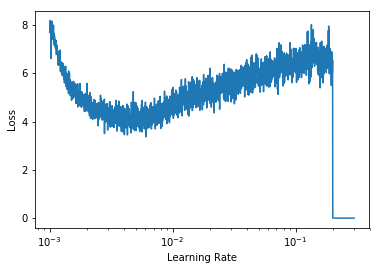

In [57]:
learner.plot_lrs(1)

In [58]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*4,n_item_final],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [59]:
learner.run_epochs(dltrain,None,5)

Batch:1000 4.2563323974609375 4.206260681152344 
Batch:2000 4.322210311889648 4.231937408447266 
Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.058649063110352  Valid Loss:4.281396865844727 
Batch:1000 4.181878566741943 4.142256736755371 
Batch:2000 4.306704998016357 4.223194122314453 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.050207614898682  Valid Loss:4.286770820617676 
Batch:1000 4.190374374389648 4.149833679199219 
Batch:2000 4.311041355133057 4.225616931915283 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.052928924560547  Valid Loss:4.286311149597168 
Batch:1000 4.189661502838135 4.149001121520996 
Batch:2000 4.3108601570129395 4.224020481109619 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.052953243255615  Valid Loss:4.285284519195557 
Batch:1000 4.190953731536865 4.145871162414551 
Batch:2000 4.311440467834473 4.228301525115967 
Epoch:4 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.053359508514404  Valid Loss:4.

In [60]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [61]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=5e-4)

In [62]:
learner.run_epochs(dltrain,None,7)

Batch:1000 4.368629455566406 4.322657585144043 
Batch:2000 4.236739158630371 4.135943412780762 
Epoch:0 Learning rate 0.002 Weight Decay 1e-07 Train Loss:3.9304044246673584  Valid Loss:4.107389450073242 
Batch:1000 4.031864643096924 3.98602557182312 
Batch:2000 3.9971530437469482 3.895148754119873 
Epoch:1 Learning rate 0.001 Weight Decay 1e-07 Train Loss:3.7315073013305664  Valid Loss:3.8978662490844727 
Batch:1000 4.140296936035156 4.142197608947754 
Batch:2000 4.012880325317383 3.9538352489471436 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:3.6990303993225098  Valid Loss:3.892282724380493 
Batch:1000 3.8826236724853516 3.8533434867858887 
Batch:2000 4.006040096282959 3.9195163249969482 
Epoch:3 Learning rate 0.002 Weight Decay 1e-07 Train Loss:3.7762291431427  Valid Loss:3.9944310188293457 
Batch:1000 3.9592463970184326 3.9105072021484375 
Batch:2000 3.993515729904175 3.8905904293060303 
Epoch:4 Learning rate 0.0014142135623730952 Weight Decay 1e-07 Train Loss:3.74842

In [63]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [64]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [65]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((100, 77806), (25, 100))

In [66]:
df_train.shape

(185974, 77806)

In [67]:
from scipy.special import expit

df_train_item_autoenc=np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)
df_valid_item_autoenc=np.tanh(expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T)

In [68]:
df_train_item_autoenc=expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T
df_valid_item_autoenc=expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T

In [69]:
df_train_item_autoenc.shape

(185974, 25)

In [70]:
df_valid_item_autoenc.shape

(185974, 25)

In [71]:
df_train_item_autoenc=pd.DataFrame(df_train_item_autoenc)
df_valid_item_autoenc=pd.DataFrame(df_valid_item_autoenc)

In [72]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([100, 77806])

In [73]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([25, 100])

In [74]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [75]:
df_train_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_train_item_autoenc.shape[1])]

In [76]:
df_valid_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_valid_item_autoenc.shape[1])]

In [77]:
df_train_item_autoenc.reset_index(inplace=True)

In [78]:
df_valid_item_autoenc.reset_index(inplace=True)

In [79]:
df_train_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)
df_valid_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)

In [80]:
import pickle
pickle.dump([df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))

In [81]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=7e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=5e-4)

In [82]:
learner.run_epochs(dltrain,None,29)

Batch:1000 4.145969390869141 4.107500076293945 
Batch:2000 4.282316207885742 4.199105739593506 
Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.033990383148193  Valid Loss:4.300541877746582 
Batch:1000 4.00278377532959 3.9490740299224854 
Batch:2000 4.023034572601318 3.921839714050293 
Epoch:1 Learning rate 0.0015811388300841897 Weight Decay 1e-07 Train Loss:3.7725586891174316  Valid Loss:3.947331190109253 
Batch:1000 4.239247798919678 4.221717357635498 
Batch:2000 4.082110404968262 4.0057878494262695 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:3.743715524673462  Valid Loss:3.9313220977783203 
Batch:1000 4.199877738952637 4.15765380859375 
Batch:2000 4.32675313949585 4.241708755493164 
Epoch:3 Learning rate 0.005 Weight Decay 1e-07 Train Loss:4.065980911254883  Valid Loss:4.339572429656982 
Batch:1000 3.9879934787750244 3.9387922286987305 
Batch:2000 4.094760894775391 4.002603530883789 
Epoch:4 Learning rate 0.0028117066259517455 Weight Decay 1e-07 Train Los